In [1]:
########## Packages ##########
import numpy as np 
from scipy import stats 
import matplotlib.pyplot as plt 

## 3.5 線形回帰の例
- 線形回帰モデルをガウス分布を使って構築
- 係数パラメータの学習
- 未観測データの予測

### 3.5.1 モデルの構築
線形回帰モデル
$$
y_n = \boldsymbol{w}^{\text{T}} \boldsymbol{x}_n + \varepsilon_n
$$
- $y_n \in \mathbb{R}$: 出力
- $\boldsymbol{x}_n \in \mathbb{R}^M$: 入力値
- $\boldsymbol{w} \in \mathbb{R}^M$: パラメータ
- $\varepsilon_n \in \mathbb{R}$: ノイズ
     $$
     \varepsilon_n \sim \mathcal{N} (\varepsilon_n | 0, \lambda^{-1})
     $$ 
     を仮定．
    - $\lambda \in \mathbb{R}_{+}$: 精度パラメータ

ノイズが正規分布に従うという仮定の下では，出力$y_n$の分布は，
$$
p(y_n | \boldsymbol{x}_n, \boldsymbol{w}) = \mathcal{N}(y_n | \boldsymbol{w}^{\text{T}}\boldsymbol{x}_n, \lambda^{-1})
$$
である．ここでは，パラメータ$\boldsymbol{w}$を観測データから学習したい．

以下の事前分布を考える．
$$
p(\boldsymbol{w}) = \mathcal{N}(\boldsymbol{w} | \boldsymbol{m}, \boldsymbol{\Lambda}^{-1})
$$
- ハイパーパラメータ
    - $\boldsymbol{m} \in \mathbb{R}^M$: 平均パラメータ
    - $\boldsymbol{\Lambda}^{-1}$: 精度行列パラメータ．正定値．

実際に動かしてみる．
- 仮定
    - $M = 4$
    - $\boldsymbol{x} = (1, x, x^2, x^3)^{\text{T}}$

次のセルで，$\boldsymbol{w}$の実現値をサンプルし，得られた$\boldsymbol{w}$の値に基づいて3次関数をプロットする．

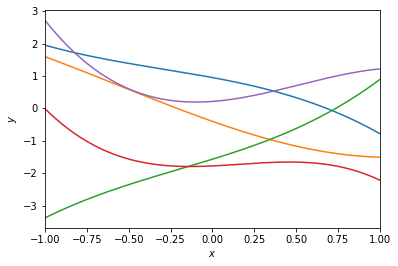

In [2]:
###################### prior distribution ######################
######################## parameter ########################
dim = 4
sample_size = 5
m_vec = np.zeros(dim)  # m = [0, 0, 0, 0]
Lambda_array = np.eye(dim)        # Lambda = diag{1, 1, 1, 1}
###########################################################

################################## generate w ~ p(w) = N(w|0, I) ##################################
w_sample = stats.multivariate_normal(m_vec, np.linalg.inv(Lambda_array)).rvs(size=sample_size)
###################################################################################################

###### generate sample points ######
x_range = np.linspace(-1, 1, 201)
Xvec_set = []
for x in x_range:
    vec = []
    for d in range(dim):
        vec.append(x**d)
    vec = np.array(vec)
    Xvec_set.append(vec)
Xvec_set = np.array(Xvec_set)
####################################

####################### y from prior #######################
y_prior = []
for k in range(sample_size):
    y_prior_sample = []
    for i in range(len(x_range)):
        y_prior_sample.append(w_sample[k].T @ Xvec_set[i])
    y_prior_sample = np.array(y_prior_sample)
    y_prior.append(y_prior_sample)
y_prior = np.array(y_prior)
############################################################

##################### plot x-y from prior model #####################
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$")
ax.set_xlim([-1, 1])
for i in range(sample_size):
    ax.plot(x_range, y_prior[i])
plt.show()
#####################################################################


次のセルでは，入力値$\boldsymbol{x}_n$を等間隔で何点か与えた上で，人工的な観測値$y_n$をシミュレートしてドットする．
- 仮定
    - $\lambda = 10.0$

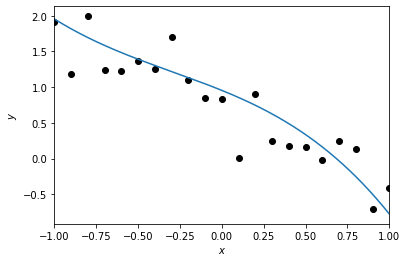

In [3]:
######################## parameter ########################
lambda_precision = 10.0
###########################################################

###### generate input value and mean param ######
x_input = np.linspace(-1, 1, 21)
mean_param_set = []
for x in x_input:
    vec = []
    for d in range(dim):
        vec.append(x**d)
    vec = np.array(vec)
    mean_param_set.append(w_sample[0].T @ vec)
#################################################

#################### generate y_n ~ N(y_n|w^T x_n, \lambda^{-1}) artificially ####################
y_obs_set = []
for i in range(len(x_input)):
    y_obs = stats.norm.rvs(loc=mean_param_set[i], scale=np.sqrt(lambda_precision**(-1)))
    y_obs_set.append(y_obs)
y_obs_set = np.array(y_obs_set)
##################################################################################################

##################### plot x-y from sample #####################
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$")
ax.set_xlim([-1, 1])
ax.plot(x_range, y_prior[0])                # plot function
ax.scatter(x_input, y_obs_set, color = "k")  # plot sample y_n
plt.show()
################################################################

- 確率分布の組み合わせ方や構成する確率分布の種類，設定する固定パラメータの値を事前に設定することで，1つの確率モデル (データの生成過程に関する1つの仮説) を明記できる．
- モデルから具体的なパラメータやデータのサンプルを得ることで，仮説がカバーしている実現例を視覚的に確認することができる
    - モデル設計の時点でいくつかのサンプルを抽出して，モデルの妥当性を確認するのが賢明である．

### 3.5.2 事後分布と予測分布の計算
- 上記で構築した線形回帰モデルを使って，データを観測したあとの事後分布と予測分布を求める．

ベイズの定理より，
$$
p(\boldsymbol{w}|\boldsymbol{Y}, \boldsymbol{X}) = \frac{p(\boldsymbol{X}, \boldsymbol{Y}, \boldsymbol{w})}{p(\boldsymbol{X}, \boldsymbol{Y})} \\
= \frac{p(\boldsymbol{w}) p(\boldsymbol{X}, \boldsymbol{Y} | \boldsymbol{w})}{p(\boldsymbol{X}, \boldsymbol{Y})} = \frac{p(\boldsymbol{w}) p(\boldsymbol{Y} | \boldsymbol{X}, \boldsymbol{w}) p(\boldsymbol{X})}{p(\boldsymbol{X}, \boldsymbol{Y})} \\
= \frac{p(\boldsymbol{w})p(\boldsymbol{Y} | \boldsymbol{X}, \boldsymbol{w})}{p(\boldsymbol{Y} | p(\boldsymbol{X}))} = \frac{p(\boldsymbol{w}) \prod_{n = 1}^N p(y_n | \boldsymbol{x}_n, \boldsymbol{w})}{p(\boldsymbol{Y} | \boldsymbol{X})} \\
\propto p(\boldsymbol{w}) \prod_{n = 1}^N p(y_n | \boldsymbol{x}_n, \boldsymbol{w})
$$
が得られる．これを$\boldsymbol{w}$について整理し，$\boldsymbol{w}$の分布の形式を明らかにする．対数をとる．
$$
\ln p(\boldsymbol{w} | \boldsymbol{Y}, \boldsymbol{X}) = - \frac{1}{2} \left( \boldsymbol{w}^{\text{T}} \left(\lambda \sum_{n = 1}^N \boldsymbol{x}_n \boldsymbol{x}_n^{\text{T}} + \boldsymbol{\Lambda} \right) \boldsymbol{w} -2 \boldsymbol{w}^{\text{T}} \left(\lambda \sum_{n = 1}^N y_n \boldsymbol{x}_n + \boldsymbol{\Lambda}\boldsymbol{m} \right) \right) + \text{const}.
$$
